In [1]:
#!pip install numpy
#!pip install scikit-learn
#!pip install pandas
#!pip install seaborn
#!pip install matplotlib
#!pip install scipy
#!pip install statsmodels

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from scipy.interpolate import interp1d
from scipy.stats import norm, bernoulli
from statsmodels.api import qqplot
import json
from itertools import chain

In [4]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



## Mission

Vous commandez un avion de reconnaissance en mission top secrète. Malgré votre discretion et toutes les précautions prises vous dérangez et pouvez être sujet de menaces qu'il vous faut détecter pour garantir la sécurité de votre équipage et la succès de votre mission (comme elle est top secrète vous ne pouvez pas en savoir plus). 

A votre disposition un réseau d'antennes et un système d'analyse spectrale perfectionnés vous permettent d'extraire et de caractériser des signaux en provenance des radars à altitude 0 qui parsèment votre parcours. 

Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient: 

- la date de début de détection de l'impulsion (en ms)
- la largeur ou durée de l'impulsion (en ms)
- la puissance de l'impulsion (en dB / référence) 
- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
- la fréquence de l'impulsion (en Ghz)

Votre capteur n'est pas parfait et vous subissez notamment un phénomène de mitage: une certaine proportion des impulsions émises ne sont pas détectées. Cette proportion est d'autant plus grande que la puissance des impulsions est petite.  

Votre vaisseau navigue à 10 km d'altitude, avec une vitesse constante de 1000 km/h vers le nord. 

De précédentes missions ont permis de réaliser une base de données de signaux de 10 secondes. 
Chaque signal se présente sous la forme d'un fichier .npz qui contient l'ensemble des PDW reçus. 

Un signal est donc un fichier dont le nom est de la forme 'pdw_<numéro du signal>.npz'.

Cette base de données est annotée: le destin de chaque mission a permis de déclarer chaque signal comme une 'menace' ou une 'nonmenace'. 

Les signaux ont été divisés en deux ensembles indépendants: 
    
- train
- test 
 
Les annotations pour chaque ensemble sont disponibles dans le fichier labels_<train ou test>.json qui donne l'association nom de fichier -> menace ou nonmenace. 
    
    
Votre mission (si vous l'acceptez) est de choisir et d'entrainer un algorithme d'apprentissage machine à détecter les menaces sur l'ensemble 'train' et à évaluer ses performances sur l'ensemble 'test'. 

<div class=consignes> On compte sur vous, bonne chance ! </div>

**Lorenzo Brucato - auditeur externe (M2 Mathématiques et Intelligence artificielle)**
___

# 1. Traitement des signaux radars

## 1.1 Chargement des données

In [12]:
import json

with open('./radars/train_labels.json') as f: 
    dict_labels = json.load(f)

with open('./radars/test_labels.json') as f:
    dict_labels_test = json.load(f)

for i in range(10):
    print(f"Le signal pdw-{i}.npz est de type: {dict_labels[f'pdw-{i}']}")

Le signal pdw-0.npz est de type: nonmenace
Le signal pdw-1.npz est de type: nonmenace
Le signal pdw-2.npz est de type: menace
Le signal pdw-3.npz est de type: nonmenace
Le signal pdw-4.npz est de type: nonmenace
Le signal pdw-5.npz est de type: menace
Le signal pdw-6.npz est de type: menace
Le signal pdw-7.npz est de type: menace
Le signal pdw-8.npz est de type: menace
Le signal pdw-9.npz est de type: nonmenace


**Traitement des données pour un signal perçu donné + méthodes pour la récupération de données explicatives pour la classification :**

In [15]:
class load_signal():

    signal_length = 10 
    high = 10
    speed = 1000
    
    def __init__(self, id0, set='train'):

        self.__pdws = np.load(f'./radars/{set}/pdw-{id0}.npz')
        
        self.dates = self.__pdws['date']        # temps des mesures
        self.freq = self.__pdws['frequence']    # frequences observées
        self.puis = self.__pdws['puissance']    # puissance du signal 
        self.theta = self.__pdws['theta']       # angle theta de provenance du signal
        self.phi = self.__pdws['phi']           # angle phi de provenance du signal
        self.width = self.__pdws['largeur']     # largeur de l'impulsion
        self.nb_pulse = len(self.dates)         # nombre de mesures
        if set=='train':
            self.menace = dict_labels[f'pdw-{id0}'] == 'menace'
        elif set=='test':
            self.menace = dict_labels_test[f'pdw-{id0}'] == 'menace'
                    
    def draw(self):
        """
        -- visualisation des caractéristiques du signal
        """
        fig, ax = plt.subplots(3, 2, figsize=(10, 10))
        ax[0, 0].scatter(self.dates, self.width, marker='+', label='width')
        ax[0, 1].plot(self.dates, self.dates, marker='+', label='dates')
        ax[1, 0].scatter(self.dates, self.puis,  marker='+', color='red', label='puis')
        ax[1, 1].scatter(self.dates, self.freq,  marker='+', color='green', label='freq')
        ax[2, 0].scatter(self.dates, self.phi,   marker='+', color='purple', label='phi')
        ax[2, 1].scatter(self.dates, self.theta, marker='+', color='purple', label='theta')
        for i in range(3) : 
            for j in range(2) : 
                ax[i, j].legend()
                ax[i, j].grid()
        if self.menace : 
            plt.suptitle(f"le signal est une menace")
        else :
            plt.suptitle(f"le signal n'est pas une menace")


    def window_fft_analysis(self, n_window=3, n_best_freqs=5, fe=2000,  plot=False):
        """
        -- analyse de la transformée de fourrier par fenêtre sur le signal de puissance
            * n_window : nombre de découpage du signal
            * n_best_freqs : conservation des n fréquences de plus grande amplitude
            * fe : fréquence d'échantillonage du signal
            * plot : affichage des transformées de fourier et interpolations du signal
        """
        means = []             # moyenne des valeurs prises par le signal sur la fenêtre i
        cs = []                # somme des fréquences pondérées par l'amplitude
        freqs = []  # (i, j) = j-ème fréquence de plus grande amplitude de la fenêtre i
        amps = []   # (i, j) = j-ème plus grande amplitude de la fenêtre i

        width = 10000.0/n_window
        x = self.puis
        n = len(x)
        
        # interpolation (pour obtenir des temps réguliers)
        interp = interp1d(self.dates, x, kind='linear')
        dt = np.linspace(min(self.dates), max(self.dates), num=n)
        x = interp(dt)
        
        if plot : fig, axs = plt.subplots(n_window, 2, figsize=(10, 4*n_window))
        
        for k in range(n_window) : 
            
            idxs = np.where((dt >= k * width) & (dt < (k+1) * width))
            times = dt[idxs]
            x_wind = x[idxs]
            n = len(idxs[0])

            # transformée de fourier
            Xf = fft(x_wind)/fe
            ff = fftfreq(n)*fe
            X = abs(fftshift(Xf))[n//2 + 1:]
            f = fftshift(ff)[n//2 + 1:]
            best_idx = np.argsort(X)[::-1][:n_best_freqs]

            means.append(np.mean(x_wind))
            freqs.append(f[best_idx])
            amps.append(X[best_idx])
            cs.append(np.sum(X * f)/np.sum(X))
            
            if plot :
                
                ax = axs[k][0]
                ax.plot(times, x_wind, color='green', label='interp1d')
                ax.plot(self.dates, self.puis, linestyle='--', color='darkgreen', label='puissance')
                ax.set_xlim(k * width, (k+1) * width)
                ax.plot([k * width, (k+1) * width], [means[k], means[k]], color='red', label='mean')
                ax.legend()
                ax.grid()
                ax.set_ylabel(f"fenêtre {k}")
    
                ax = axs[k][1]
                ax.plot(f, X, color='blue')
                ax.scatter(freqs[k], amps[k], color='red', marker='+', label='best_freq')
                ax.legend()
                ax.grid()
                ax.set_xlabel('Fréquence')
                ax.set_ylabel('Amplitude')

        if plot : 
            axs[0][0].set_title("Interpolation")
            axs[0][1].set_title("Transformée de fourier")

        
        return pd.DataFrame({
            "means":means,
            "freqs":freqs,
            "amps":amps,
            "cs":cs
        })

**Collecte des features :** Les données explicatives extraites de chaque signal sont les suivantes :

- `freq_est` : la frequence moyenne de l'impulsion observé au cours du temps (on suppose un bruit gaussien sur l'ensemble des mesures : cf. visualisation)
- `freq_std` : l'écart type des mesures de fréquence
- `width_est` : la largeur d'impulsion moyenne observée
- `phi_est` : l'angle phi moyen estimé
- `phi_std` : ecart type des mesures de l'angle phi
- `mean_theta` : angle theta moyen
- `freq_puisX` : moyenne des fréquences les plus significatives dans la décomposition de fourier du signal de puissance (fenêtre X de 1 à 3)
- `amp_puisX` : l'amplitude totale des fréquences correpondantes (fenêtre X de 1 à 3)
- `mean_puisX` : moyenne des valeurs du signal sur la fenêtre X
- `csX` : somme des fréquences pondérées par l'amplitude de la décomposition de fourier de la fenêtre X
- `length` : nombre de mesures du signal

*variable cible* : `menace` indique si le signal est une menace ou non

In [17]:
columns = ['freq_est', 'freq_std', 'width_est',
               'phi_est', 'phi_std', 'mean_theta',
               'freq_puis1', 'freq_puis2', 'freq_puis3',
               'amp_puis1', 'amp_puis2', 'amp_puis3',
               'mean_puis1', 'mean_puis2', 'mean_puis3',
               'cs1', 'cs2', 'cs3',
               'length', 'menace']


train = pd.DataFrame(columns = columns)
test = pd.DataFrame(columns = columns)

for i in range(len(dict_labels)):
    
    signal = load_signal(i) 

    wa = signal.window_fft_analysis(n_window=3, n_best_freqs=10)
    f1, f2, f3 = [np.mean(wa["freqs"][i]) for i in range(3)]
    a1, a2, a3 = [np.sum(wa["amps"][i]) for i in range(3)]
    u1, u2, u3 = list(wa["means"])
    c1, c2, c3 = list(wa["cs"])   
    
    length = len(signal.dates)
    std_puiss = np.std(signal.puis)
    
    train.loc[i] = [
        np.mean(signal.freq),
        np.std(signal.freq),
        np.mean(signal.width),
        np.mean(signal.phi),
        np.std(signal.phi),
        np.mean(signal.theta),
        f1, f2, f3,
        a1, a2, a3,
        u1, u2, u3,
        c1, c2, c3,
        length,
        signal.menace
    ]

for i in range(len(dict_labels_test)):
    signal = load_signal(i, set='test') 
    
    wa = signal.window_fft_analysis(n_window=3, n_best_freqs=5)
    f1, f2, f3 = [np.mean(wa["freqs"][i]) for i in range(3)]
    a1, a2, a3 = [np.sum(wa["amps"][i]) for i in range(3)]
    u1, u2, u3 = list(wa["means"])
    c1, c2, c3 = list(wa['cs'])
    
    length = len(signal.dates)
    std_puiss = np.std(signal.puis)
    
    test.loc[i] = [
        np.mean(signal.freq),
        np.std(signal.freq),
        np.mean(signal.width),
        np.mean(signal.phi),
        np.std(signal.phi),
        np.mean(signal.theta),
        f1, f2, f3,
        a1, a2, a3,
        u1, u2, u3,
        c1, c2, c3,
        length,
        signal.menace
    ]


In [19]:
train

,freq_est,freq_std,width_est,phi_est,phi_std,mean_theta,freq_puis1,freq_puis2,freq_puis3,amp_puis1,amp_puis2,amp_puis3,mean_puis1,mean_puis2,mean_puis3,cs1,cs2,cs3,length,menace
0,2.202149,0.008909,0.292003,1.574437,0.155398,-1.334458,68.750000,63.392857,66.964286,2.961410,1.949852,1.915674,-146.152746,-147.130411,-163.534232,227.050851,213.277211,254.369521,672,False
1,2.996037,0.012328,0.137017,1.570940,0.161758,-1.634125,42.222222,52.222222,36.565097,3.334425,4.520460,3.263733,-148.357478,-154.403231,-155.669755,173.954177,165.406215,144.038237,1081,False
2,0.986435,0.004003,0.201962,1.571787,0.154042,-1.607840,69.483568,181.132075,80.952381,2.009795,1.471547,2.202552,-170.825975,-176.579821,-167.583660,210.819000,307.637540,235.208446,635,True
3,1.665592,0.006610,0.069014,1.585633,0.162123,-1.690380,29.645094,32.567850,25.000000,3.909493,3.329133,4.078047,-148.541123,-155.879235,-145.053182,130.369753,180.229361,160.444766,1438,False
4,2.205039,0.008529,0.324018,1.578277,0.161913,-1.559266,72.636816,82.178218,88.669951,2.024088,1.430283,1.611264,-168.934425,-181.822885,-180.686162,179.341185,199.754194,247.183466,606,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.247535,0.070869,0.143991,1.574064,0.161461,-1.574284,41.304348,60.704607,82.162162,3.713011,3.457129,2.991077,-179.773148,-179.119366,-195.451967,237.611498,180.517567,305.045224,1107,True
1996,1.878550,0.109245,0.159961,1.575663,0.158298,-1.563371,43.916914,35.014837,55.621302,2.482863,3.235128,2.440241,-142.894963,-143.017215,-158.252228,196.560050,129.753905,199.654278,1012,True
1997,1.917764,0.007621,0.028000,1.572314,0.156688,-1.513623,9.896603,9.594096,13.864307,13.776065,11.691948,11.535784,-145.249201,-141.248883,-159.946733,118.312459,175.932568,153.958816,4065,True
1998,2.040005,0.008051,0.107006,1.574144,0.153207,-1.527002,24.555160,31.802120,23.362832,5.442258,3.706869,5.796793,-148.721887,-154.672356,-149.024211,200.301844,159.475876,137.649511,1693,True


## 1.2 Analyse et visualisation

### 1.2.1 Analyse descriptive des données et correlations

**Toutes les données sont complètes :**

In [23]:
pd.isna(train).sum().sum()

0

In [24]:
pd.isna(test).sum().sum()

0

**Description des données :**

In [26]:
train.describe()

,freq_est,freq_std,width_est,phi_est,phi_std,mean_theta,freq_puis1,freq_puis2,freq_puis3,amp_puis1,amp_puis2,amp_puis3,mean_puis1,mean_puis2,mean_puis3,cs1,cs2,cs3,length
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1.928007,0.024230,0.149072,1.572640,0.157118,-1.542772,44.202832,49.047521,49.988713,5.298764,4.417771,4.181260,-149.655281,-155.626479,-160.207395,196.907654,190.121062,198.822720,1698.798000
std,0.878697,0.035083,0.100390,0.005089,0.003536,0.088269,26.431089,30.911084,31.602351,6.108565,5.398992,5.211950,16.307428,15.399389,15.554734,37.486258,44.601157,54.312943,1842.561227
min,0.542676,0.002117,0.003997,1.547765,0.142163,-1.724333,2.278861,2.203229,2.518363,0.682597,0.226952,0.139549,-215.554858,-216.165229,-221.969461,110.743359,104.521952,99.761078,458.000000
25%,1.240717,0.005783,0.069738,1.569537,0.155014,-1.616679,23.300022,25.161917,26.053617,2.133675,1.716058,1.687398,-158.046365,-164.300425,-169.140700,169.949352,155.462470,155.830064,692.750000
50%,1.748150,0.008727,0.130064,1.572684,0.157072,-1.540734,42.395922,45.607412,46.828191,3.156033,2.696182,2.551777,-150.613396,-156.550811,-161.237506,193.666995,182.600639,189.065151,1013.500000
75%,2.437274,0.015065,0.210985,1.575570,0.159361,-1.470882,60.946250,66.427057,66.968497,5.749954,4.737376,4.590752,-144.658951,-148.577607,-153.558180,220.507626,223.160356,234.311036,1855.250000
max,4.981212,0.173049,0.486997,1.590117,0.169202,-1.334458,262.427746,246.560847,259.550562,56.391884,73.805140,68.150226,-107.967933,-121.982823,-126.784129,390.633669,398.149769,373.711240,20014.000000


On peut observer que l'angle phi de la direction du signal semble globalement le même pour l'intégralité des signaux, avec extrêmement peu de variabilité sur les mesures moyennes. (cf. visualisation)

**Matrice des correlations :**

On regarde les facteurs les plus susceptibles d'être significatifs pour les modèles d'apprentissage :

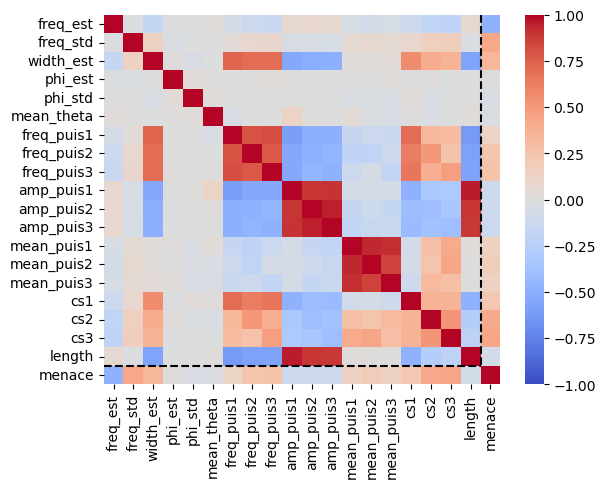

In [30]:
fig, ax = plt.subplots(1, 1)
sns.heatmap(train.corr(), annot=False, vmin = -1, vmax = 1 , cmap='coolwarm', ax=ax)
nvarexp = train.shape[1] - 1
ax.plot([0, nvarexp], [nvarexp, nvarexp], linestyle='--', color='black')
ax.plot([nvarexp, nvarexp], [0, nvarexp], linestyle='--', color='black')

On observe ici que les données sur la fréquence et la puissance sont fortement corrélées au type du signal. A l'inverse, les informations sur les angles de direction de provenance (en moyenne) ne permettent a priori pas d'obtenir directement des informations pertinentes sur le type du signal.

### 1.2.2 Visualisation et choix/compréhension des données

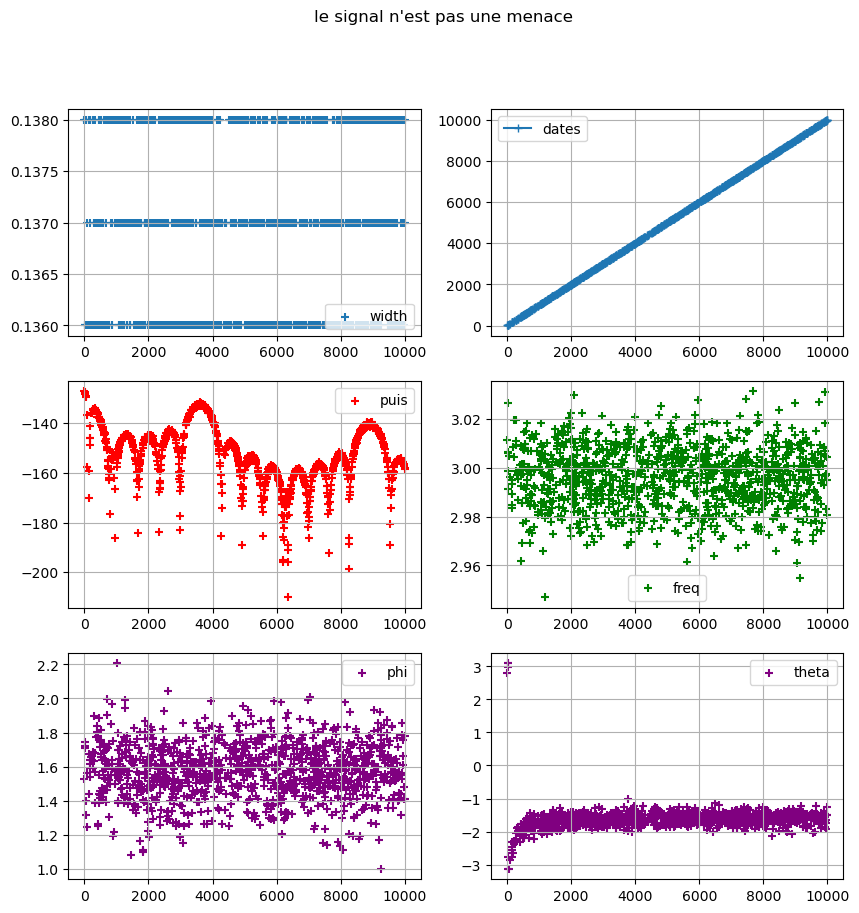

In [33]:
signal = load_signal(1)
signal.draw()

D'après les visualisations que l'on peut réaliser sur les différents signaux ci-dessus, on regardera dans un premier temps si l'on peut supposer un bruit gaussien pour les composantes de frequence et sur l'angle phi : cela permet de prendre la moyenne et l'écart type observés pour résumer l'information de ces données.

Pour la donnée de puissance, on observe des phénomènes périodiques et des variations significatives au cours du temps. On analysera ce signal de manière plus approfondie par la suite.

In [35]:
# standardisation des composantes des angles phi et freq
phi_norm = (signal.phi - np.mean(signal.phi))/np.std(signal.phi)
freq_norm = (signal.freq - np.mean(signal.freq))/np.std(signal.freq)

**Distribution normale sur l'angle phi :**

QQplot et superposition de la densité normale sur les mesures de phi :

Text(0.5, 1.0, 'Distribution des données observées')

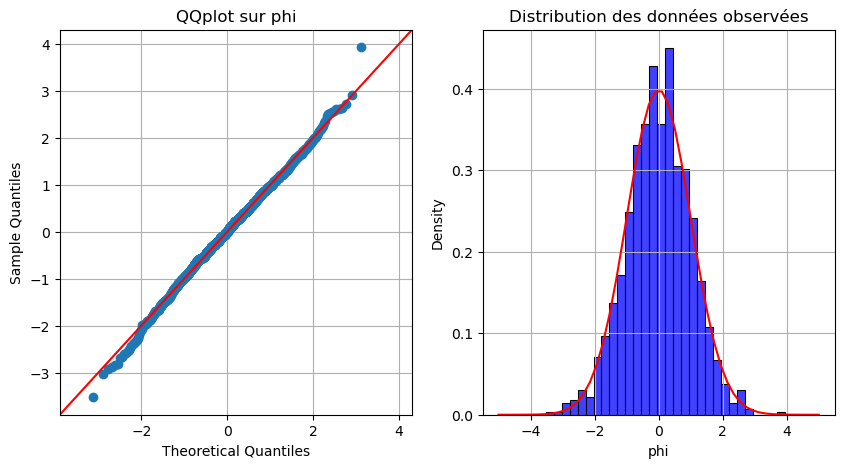

In [38]:
# qqplot phi
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

qqplot(phi_norm, line='45', ax=axs[0])
axs[0].grid()
axs[0].set_title('QQplot sur phi')

sns.histplot(phi_norm, bins=30, edgecolor='black', stat='density', color='blue', ax=axs[1])
xx = np.linspace(-5, 5, 50)
axs[1].plot(xx, norm.pdf(xx, 0, 1), color='red')
axs[1].grid()
axs[1].set_xlabel("phi")
axs[1].set_title("Distribution des données observées")

Distribution de la moyenne observée sur l'ensemble des signaux :

0.005087863364975488


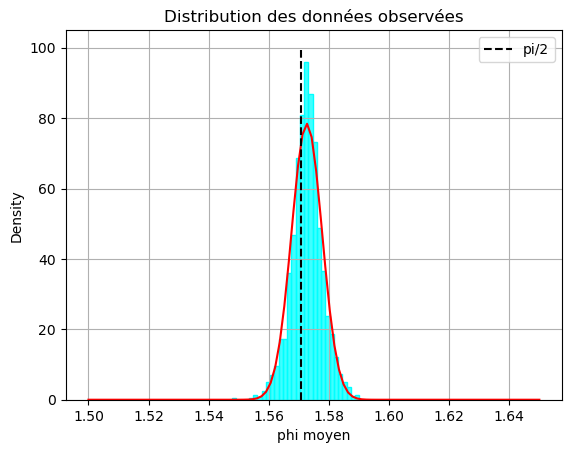

In [40]:
phi_mean = np.mean(train['phi_est'])
phi_std = np.std(train['phi_est'])
print(phi_std)
sns.histplot(train['phi_est'], bins=30, edgecolor='cyan', stat='density', color='cyan')
xx = np.linspace(1.5, 1.65, 100)
plt.plot(xx, norm.pdf(xx, phi_mean, phi_std), color='red')
plt.grid()
plt.xlabel("phi moyen")
plt.title("Distribution des données observées")
plt.plot([np.pi/2, np.pi/2], [0, 100], color='black', linestyle='--', label="pi/2")
plt.legend()

Au vu de l'adéquation de la distribution des données avec les quantiles théoriques, on fait ici l'hypothèse que les mesures observées suivent un bruit gaussien. On résume ainsi l'information par la moyenne et l'écart type observé sur l'ensemble des mesures.

Cependant, en regardant de nouveau les angles estimés, on constate que cette mesure reste globalement identique suivant les signaux et ne permet pas de pouvoir distinguer ou interpréter directement le type d'un signal. Puisqu'il n'y a pas de correlation, on ne se servira pas de cette donnée dans les modèles d'apprentissage.

**Distribution normale sur le paramètre de fréquence :**

De la même façon, on fait l'hypothèse d'un bruit gaussien sur la mesure des fréquences, et on résume l'information en prenant la moyenne estimée ainsi que l'écart type des données :

Text(0.5, 1.0, 'Distribution des données observées')

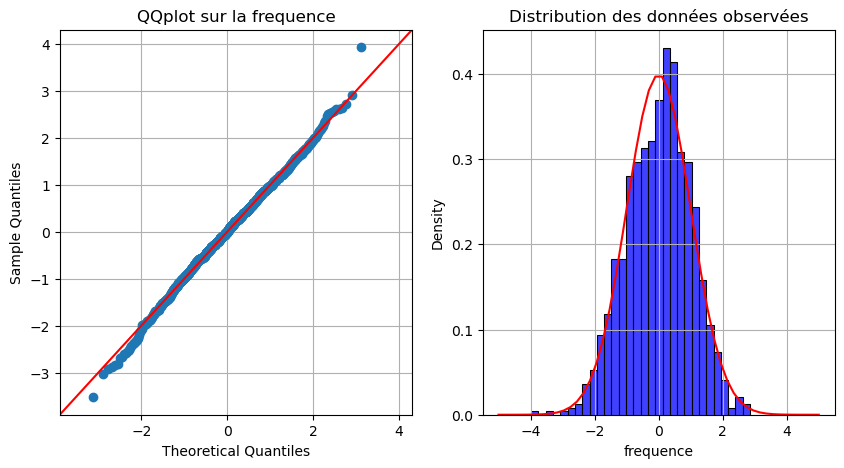

In [45]:
# qqplot phi
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

qqplot(phi_norm, line='45', ax=axs[0])
axs[0].grid()
axs[0].set_title('QQplot sur la frequence')

sns.histplot(freq_norm, bins=30, edgecolor='black', stat='density', color='blue', ax=axs[1])
xx = np.linspace(-5, 5, 50)
axs[1].plot(xx, norm.pdf(xx, 0, 1), color='red')
axs[1].grid()
axs[1].set_xlabel("frequence")
axs[1].set_title("Distribution des données observées")

**Distribution de la fréquence moyenne selon le type de signal :**

Contrairement à la mesure de l'angle phi, on remarque ici que les fréquences moyennes estimées diffèrent selon les signaux. Les basses fréquences discriminent davantage les signaux de type menace (et réciproquement pour les hautes fréquences) :

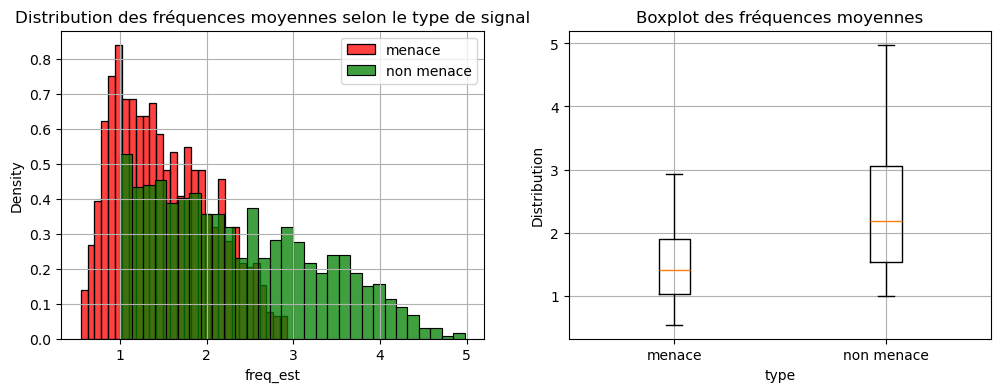

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
sns.histplot(train.loc[train['menace'] == True, "freq_est"], bins=30, edgecolor='black', stat='density', color='red', label='menace', ax=ax)
sns.histplot(train.loc[train['menace'] == False, "freq_est"], bins=30, edgecolor='black', stat='density', color='green', label='non menace', ax=ax)
ax.grid()
ax.set_title("Distribution des fréquences moyennes selon le type de signal")
ax.legend()

ax = axs[1]
ax.boxplot([ train.loc[train['menace'] == True, "freq_est"], train.loc[train['menace'] == False, "freq_est"] ], labels = ['menace', 'non menace'])
ax.set_title("Boxplot des fréquences moyennes")
ax.set_xlabel("type")
ax.set_ylabel("Distribution")
ax.grid()

**Distribution des largeurs d'impulsion moyennes selon le type de classes :**

On réalise un constat similaire pour les mesures sur les largeurs d'impulsion moyennes mesurées :

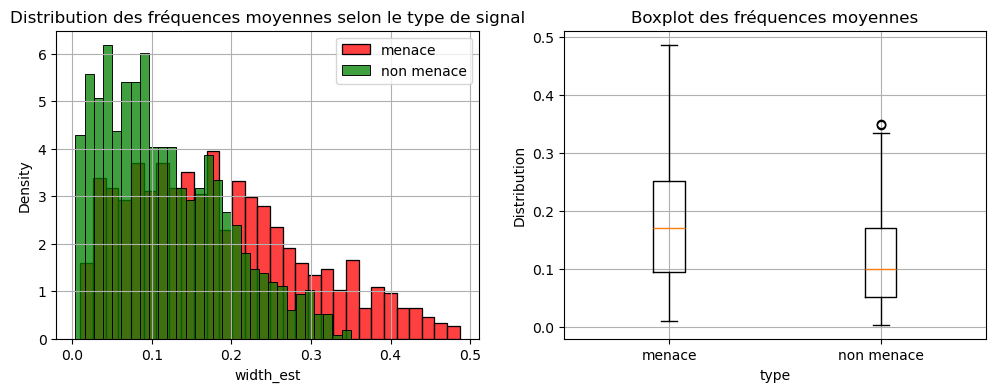

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
sns.histplot(train.loc[train['menace'] == True, "width_est"], bins=30, edgecolor='black', stat='density', color='red', label='menace', ax=ax)
sns.histplot(train.loc[train['menace'] == False, "width_est"], bins=30, edgecolor='black', stat='density', color='green', label='non menace', ax=ax)
ax.grid()
ax.set_title("Distribution des fréquences moyennes selon le type de signal")
ax.legend()

ax = axs[1]
ax.boxplot([ train.loc[train['menace'] == True, "width_est"], train.loc[train['menace'] == False, "width_est"] ], labels = ['menace', 'non menace'])
ax.set_title("Boxplot des fréquences moyennes")
ax.set_xlabel("type")
ax.set_ylabel("Distribution")
ax.grid()

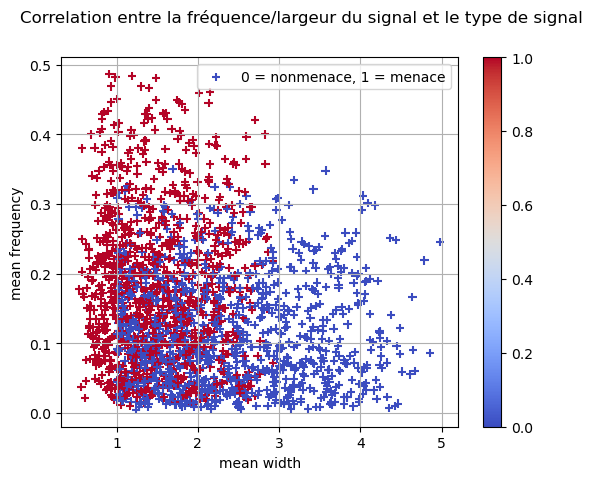

In [52]:
fig, ax = plt.subplots(1, 1)
plt.scatter(train['freq_est'], train['width_est'], c=train['menace'], marker='+', cmap='coolwarm', label='0 = nonmenace, 1 = menace')
plt.grid()
plt.xlabel("mean width")
plt.ylabel("mean frequency")
plt.suptitle("Correlation entre la fréquence/largeur du signal et le type de signal")
plt.legend()
plt.colorbar()

**Analyse en temps et fréquence du signal de puissance :**

Pour le signal de puissance, on observe une tendance périodique sur de nombreux signaux ainsi qu'un comportement qui évolue durant le temps. Pour extraire des caractéristiques pertinentes pour cette donnée, on réalise une transformée de fourier par fenêtre afin d'extraire des fréquences/amplitudes significatives durant le temps : on affiche ci-dessous la répartition des fréquences moyennes et amplitudes cumulées observées sur les 10 plus hautes fréquences, sur trois fenêtres successives : 

Text(0.5, 0, "moyenne des frequences d'amplitudes maximales")

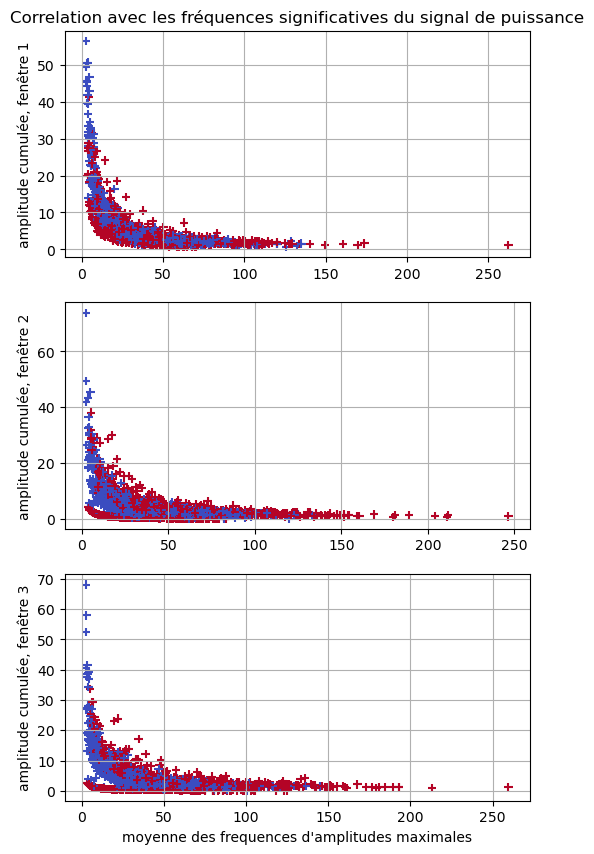

In [60]:
fig, axs = plt.subplots(3, 1, figsize=(6, 10))
axs[0].set_title("Correlation avec les fréquences significatives du signal de puissance")
for i in range(3):
    ax = axs[i]
    ax.grid()
    ax.scatter(train[f'freq_puis{i+1}'], train[f'amp_puis{i+1}'], marker='+', c=train['menace'], cmap='coolwarm', label='red : menace')
    ax.set_ylabel(f"amplitude cumulée, fenêtre {i+1}")
    
axs[2].set_xlabel(f"moyenne des frequences d'amplitudes maximales")
    

On remarque ici que des composantes fréquentielles dominantes en moyenne élevées sont plus souvent associées à des signaux malveilllants. On visualise également un cluster de signaux de type 'menace' se formant au cours du temps, caractérisé par des fréquences plus basses et une amplitude cumulée également peu élevée. Cela concerne des signaux dont la puissance se dégrade au cours du temps et affichant peu de périodicité :

Text(0.5, 0.98, 'Quelques signaux de type menace avec dégradation de la puissance du signal')

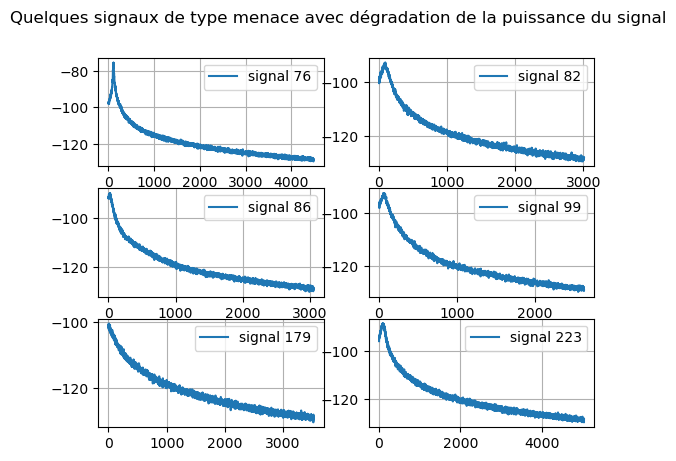

In [63]:
# récupération de quelques signaux concernés :
idxs = train.loc[train['amp_puis3'] < 5].loc[train['freq_puis3'] < 15].loc[train['menace'] == True].index[0:6]

fig, axs = plt.subplots(3, 2)
for i in range(3):
    for j in range(2):
        axs[i][j].plot(load_signal(idxs[2*i + j]).puis, label = f'signal {idxs[2*i + j]}')
        axs[i][j].grid()
        axs[i][j].legend()

fig.suptitle('Quelques signaux de type menace avec dégradation de la puissance du signal')

**PCA sur les caractéristiques de puissance :**

En moyennant les fréquences et les amplitudes caractéristiques, on perd possiblement de l'information pertinente pour mieux distinguer les signaux (fréquences caractéristiques précises et amplitudes associées).

On projete ici l'ensemble des données sur les axes caractéristiques (conservant le maximum d'inertie/variabilité sur les données) pour conserver l'information pertinente tout en supprimant les correlations importantes entre les données explicatives (permet de limiter la complexité et le surapprentissage des modèles) :

On récupère cette fois les données sur cinq fenêtres successives : 

In [70]:
# récupération d'un ensemble de données caractéristiques sur le signal de puissance (fréquences caractéristiques sur chaque fenêtre,
# amplitude associée, moyenne sur la fenêtre, somme des fréquences pondérées)
def puisDf(n_window = 5, best_freqs = 10, fe = 2000, set='train') : 

    df_columns = [f'f{i}{j}' for i in range(n_window) for j in range(best_freqs)] \
        + [f'a{i}{j}' for i in range(n_window) for j in range(best_freqs)] \
        + [f'means{i}' for i in range(n_window)] \
        + [f'cs{i}' for i in range(n_window)]

    puis_df = pd.DataFrame(columns=df_columns)

    if set == 'train' : size = len(dict_labels)
    else : size = len(dict_labels_test)
        
    for i in range(size):
        fft_analysis = load_signal(i, set=set).window_fft_analysis(n_window=n_window, n_best_freqs=best_freqs, fe=fe, plot=False)
        new_row = list(chain.from_iterable(fft_analysis['freqs'])) + list(chain.from_iterable(fft_analysis['amps'])) + list(fft_analysis['means']) + list(fft_analysis['cs'])
        puis_df.loc[i] = new_row

    return puis_df
            

trainPuis = puisDf()
testPuis = puisDf(set='test')

On effectue la projection :

Text(0, 0.5, 'dim 4')

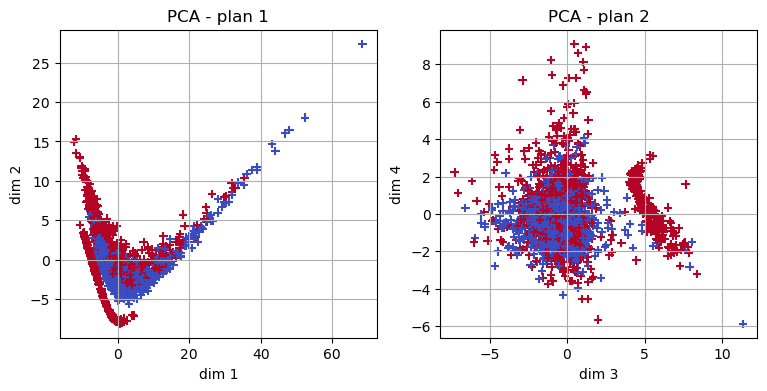

In [74]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

scaler = StandardScaler()
pca = PCA(n_components = 4)

pcaPuisDf =  pd.DataFrame(pca.fit_transform(scaler.fit_transform(trainPuis)))
axs[0].scatter(pcaPuisDf[0], pcaPuisDf[1], marker='+', c=train['menace'], cmap='coolwarm')
axs[0].grid()
axs[0].set_title("PCA - plan 1")
axs[0].set_xlabel('dim 1')
axs[0].set_ylabel('dim 2')

axs[1].scatter(pcaPuisDf[2], pcaPuisDf[3], marker='+', c=train['menace'], cmap='coolwarm')
axs[1].grid()
axs[1].set_title("PCA - plan 2")
axs[1].set_xlabel('dim 3')
axs[1].set_ylabel('dim 4')

Comme on peut l'observer ci-dessus, la PCA permet ici de distinguer encore davantage les différents clusters sur les signaux. 

In [78]:
# données de projection pour train et test
pca = PCA(n_components = 4)
scaler = StandardScaler()



pcaTrainPuis = pd.DataFrame(pca.fit_transform(scaler.fit_transform(trainPuis)), columns=["puis_pca_dim1", "puis_pca_dim2", "puis_pca_dim3", "puis_pca_dim4"])
pcaTestPuis = pd.DataFrame(pca.transform(scaler.transform(testPuis)), columns=["puis_pca_dim1", "puis_pca_dim2", "puis_pca_dim3", "puis_pca_dim4"] )

In [79]:
replaced_features = ['freq_puis1', 'freq_puis2', 'freq_puis3',
               'amp_puis1', 'amp_puis2', 'amp_puis3',
               'mean_puis1', 'mean_puis2', 'mean_puis3',
               'cs1', 'cs2', 'cs3']

if not("puis_pca_dim1" in train.columns):
    train = pd.concat( (pcaTrainPuis, train.drop(replaced_features, axis=1)), axis=1)
    
if not("puis_pca_dim1" in test.columns):
    test = pd.concat( (pcaTestPuis, test.drop(replaced_features, axis=1)), axis=1)

# 2. Inférence

## 2.1 Jeu d'entrainement et algorithme de prédiction naïf

**Train/Test:**

Pour le jeu d'entrainement, on conserve l'intégralité des features à l'exception des mesures sur les angles et du nombre de mesures qui n'affichent pas de correlations significatives avec le type de signal (et dont on a pas d'interprétation directe de ces mesures pour qualifier le type de signal) et on remplace également les données de puissance par les caractéristiques résumées par l'analyse en composantes principales. On conserve les mesures obtenues sur les fréquences, l'impulsion du signal et les caractéristiques principales du signal de puissance (PCA)  :

In [85]:
from sklearn.preprocessing import StandardScaler

drops = ['menace', 'phi_est', 'phi_std', 'mean_theta', 'length']

scaler = StandardScaler()

Xtrain = scaler.fit_transform(train.drop(drops, axis=1))
Ytrain = train['menace']

Xtest = scaler.transform(test.drop(drops, axis=1))
Ytest = test['menace']

On observe que les classes sont également correctement équilibrées sur les deux types, ce qui permettra d'interpréter plus facilement la matrice de confusion et le score des modèles :

Text(0.5, 1.0, 'proportion type menace - test')

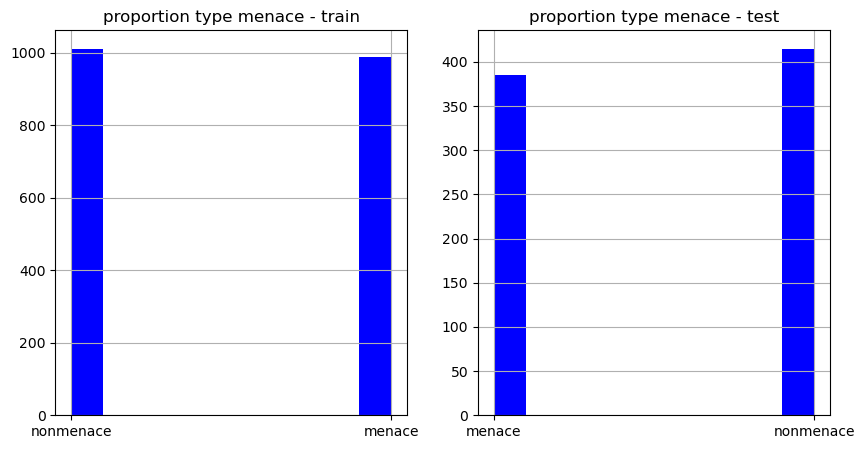

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
trainMenaces = [("menace" * b) + ("nonmenace" * (not(b))) for b in Ytrain ]
testMenaces = [("menace" * b) + ("nonmenace" * (not(b))) for b in Ytest ]

axs[0].hist(trainMenaces, color='blue')
axs[0].grid()
axs[0].set_title('proportion type menace - train')

axs[1].hist(testMenaces, color='blue')
axs[1].grid()
axs[1].set_title('proportion type menace - test')

**Prediction naïve :** on sélectionne aléatoirement la classe, pondérée par la proportion de menaces du jeu d'entrainement :

In [89]:
from scipy.stats import bernoulli
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve

p = np.sum(Ytrain == True)/len(Ytrain)
Ypred_naif = bernoulli.rvs(p, size=len(Ytest), random_state=42)

print('Attribution aléatoire')
print(f'  * accuracy_score : {accuracy_score(Ypred_naif, Ytest)}')
print(f'  * f1_score : {f1_score(Ypred_naif, Ytest)}')

Attribution aléatoire
  * accuracy_score : 0.4925
  * f1_score : 0.48346055979643765


Text(0.5, 1.0, 'Matrice de confusion')

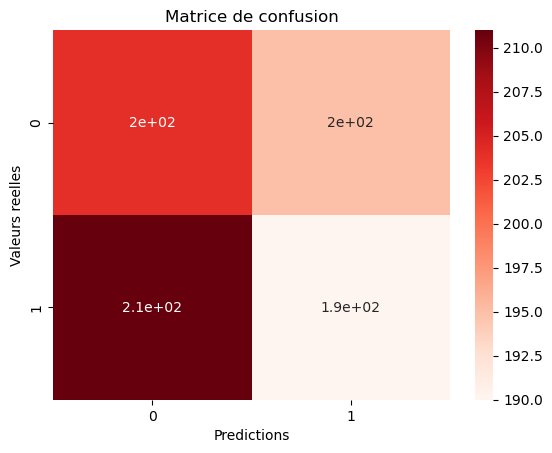

In [90]:
fig, ax = plt.subplots(1, 1)
sns.heatmap(confusion_matrix(Ypred_naif, Ytest), annot=True, cmap='Reds', ax=ax)
ax.set_ylabel("Valeurs reelles")
ax.set_xlabel("Predictions")
ax.set_title("Matrice de confusion")

On cherche désormais à trouver et paramétrer des modèles permettant d'augmenter significativment le score naïf obtenu ci-dessus.

## 2.2 Algorithmes d'apprentissage automatique

**Analyse grid search**

On utilise la classe suivante pour visualiser les scores obtenus par validation croisée sur différents modèles afin de sélectionner d'éventuels hyperparamètres.
On utilise deux métriques d'évaluation : 
- `accuracy score` : taux de bien classés sur le nombre total de données

$$
AS = \frac{TP + TN}{TP + TN + FP + FN}
$$

- `f1 score` : moyenne harmonisée de la précision et du rappel (pour tenir compte de la proportion effective de chaque classe) :

$$
F1 = 2 \frac{precision.recall}{precision + recall}
$$

In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score


scoring = {
    'f1_score': make_scorer(f1_score, greater_is_better=True),
    'acc_score': make_scorer(accuracy_score, greater_is_better=True),
}

class GridSearchAnalysis():

    def __init__(self, model, Xtrain, Ytrain, scoring, n_folds=5, param_grid={}, refit=None):

        # metrique de réévaluation du meilleur modèle
        if refit == None : refit = list(scoring.keys())[0]

        # grid search
        grid_search = GridSearchCV(model, param_grid=param_grid, scoring=scoring, refit=refit, cv=n_folds).fit(Xtrain, Ytrain)
    
        self.__params = list(param_grid.keys())
        self.__metrics = list(scoring.keys())
        self.__n_folds = n_folds

        # resultats détaillés
        results = grid_search.cv_results_
    
        # affichage dans un dataframe
        self.__results = pd.DataFrame({})
        self.__results['mean_fit_time'] = results['mean_fit_time']
        self.__results['std_fit_time'] = results['std_fit_time']

        for key_param in self.__params :
            self.__results[key_param] = [results['params'][i][key_param] for i in range(len(results['params']))]
        
        for metric in self.__metrics:
            self.__results['mean_' + metric] = np.abs(results['mean_test_' + metric])
            self.__results['std_' + metric] = np.abs(results['std_test_' + metric])

        self.__results
        
    # retour des résultats
    def score_table(self, groupBy=None, synthetic=True):
        res = self.__results.copy()
        if groupBy in self.__params : 
            res = res.groupby(groupBy).mean() 
        if synthetic : 
            res['fit_time'] = [f'{res['mean_fit_time'].iloc[i]:.3f} ± {res['std_fit_time'].iloc[i]:.3f}' for i in range(len(res['mean_fit_time']))]
            res = res.drop('mean_fit_time', axis=1)
            res = res.drop('std_fit_time', axis=1)
            for metric in self.__metrics :
                res[metric] = [f'{abs(res['mean_' + metric].iloc[i]):.3f} ± {res['std_' + metric].iloc[i]:.3f}' for i in range(len(res['mean_' + metric]))]
                res = res.drop('mean_' + metric, axis=1)
                res = res.drop('std_'  + metric, axis=1)
        return res
    
    def plot_score(self, metric=None, groupBy=None):

        if metric == None : metric = self.__metrics[0]

        fig, ax = plt.subplots(1, 1, figsize=(6, 4))

        ax.grid()
        res = self.score_table(groupBy=groupBy, synthetic=False)

        if groupBy == None :  
            ax.plot(res['mean_' + metric], color='red', marker='o', label='mean')
            ax.plot(res['mean_' + metric] + res['std_' + metric], linestyle='--', color='black', label='std')
            ax.plot(res['mean_' + metric] - res['std_' + metric], linestyle='--', color='black')
            ax.set_xlabel('param config id')
            ax.set_ylabel(metric)
            ax.set_title(f'{metric} depending on complexity, CV={self.__n_folds}')

        else :
            ax.plot(res.index, res['mean_' + metric], color='red', marker='o', label=f'mean-{metric}, groupByMean={groupBy}')
            ax.plot(res.index, res['mean_' + metric] + res['std_' + metric], linestyle='--', color='black', label=f'std-{metric}, groupByMean={groupBy}')
            ax.plot(res.index, res['mean_' + metric] - res['std_' + metric], linestyle='--', color='black')
            ax.set_xlabel(groupBy)
            ax.set_ylabel(metric)
            ax.set_title(f'{metric} depending on {groupBy} (mean groupBy), CV={self.__n_folds}')

        ax.legend()

**Regression logistique :**

On regarde l'efficacité d'un modèle de regression logistique sur les données, permettant de se donner un premier modèle simple de référence pour la suite :

In [98]:
from sklearn.linear_model import LogisticRegression

LRmodel = LogisticRegression(max_iter=1000)

LR_CV = GridSearchAnalysis(LRmodel, Xtrain, Ytrain, scoring, n_folds=5)

LR_CV.score_table()

,fit_time,f1_score,acc_score
0,0.003 ± 0.001,0.834 ± 0.005,0.841 ± 0.006


On obtient ici 84% d'accuracy en moyenne par validation croisée sur le jeu d'entrainement et 83% sur le jeu de test, ce qui est déjà une première amélioration nette du score naïf :

In [100]:
LRmodel.fit(Xtrain, Ytrain)

Ypred = LRmodel.predict(Xtest)

print('Regression logistique')
print(f'  * accuracy_score : {accuracy_score(Ypred, Ytest)}')
print(f'  * f1_score : {f1_score(Ypred, Ytest)}')

Regression logistique
  * accuracy_score : 0.835
  * f1_score : 0.824468085106383


Text(0.5, 1.0, 'Matrice de confusion')

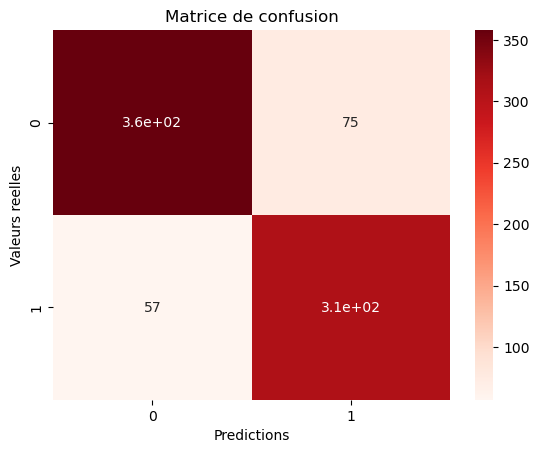

In [101]:
fig, ax = plt.subplots(1, 1)
sns.heatmap(confusion_matrix(Ypred, Ytest), annot=True, cmap='Reds', ax=ax)
ax.set_ylabel("Valeurs reelles")
ax.set_xlabel("Predictions")
ax.set_title("Matrice de confusion")

On obtient une confusion relativement équilibrée entre les faux positifs et les faux négatifs (compte tenu du fait que les proportions des signaux de type menace et non menace sont équilibrés dans le jeu de test). En considérant la détection des menaces plus importantes, on peut ici faire varier le seuil de probabilité pour améliorer la valeur de rappel (mais diminuant la précision du modèle en parallèle)

**SVM : (noyau gaussien)**

In [104]:
from sklearn.svm import SVC

SVmodel = SVC(kernel="rbf")

param_grid = {
    "gamma":[0.01, 0.1, 1.0],
    "C":[0.01, 0.1, 1.0, 5.0]
}

SV_CV = GridSearchAnalysis(SVmodel, scaler.fit_transform(Xtrain), Ytrain, scoring, n_folds=5, param_grid=param_grid)

In [105]:
SV_CV.score_table()

,gamma,C,fit_time,f1_score,acc_score
0,0.01,0.01,0.050 ± 0.002,0.168 ± 0.036,0.551 ± 0.011
1,0.10,0.01,0.044 ± 0.002,0.829 ± 0.008,0.839 ± 0.006
2,1.00,0.01,0.049 ± 0.001,0.000 ± 0.000,0.505 ± 0.001
3,0.01,0.10,0.035 ± 0.001,0.818 ± 0.010,0.838 ± 0.007
4,0.10,0.10,0.024 ± 0.001,0.843 ± 0.011,0.855 ± 0.008
5,1.00,0.10,0.040 ± 0.001,0.826 ± 0.013,0.819 ± 0.016
6,0.01,1.00,0.023 ± 0.000,0.834 ± 0.010,0.849 ± 0.007
7,0.10,1.00,0.020 ± 0.000,0.875 ± 0.010,0.881 ± 0.010
8,1.00,1.00,0.036 ± 0.003,0.870 ± 0.016,0.874 ± 0.015
9,0.01,5.00,0.022 ± 0.001,0.852 ± 0.010,0.862 ± 0.008


En comparant les résultats en validation croisée ci-dessus, on décide d'utiliser un modèle SVM à noyau gaussien pour la classification finale, avec les paramètres : 
- régularisation `C` : 5.0
- coefficient de noyau `gamma`: 0.1

SVM rbf
  * accuracy_score : 0.88375
  * f1_score : 0.8758344459279038


Text(0.5, 1.0, 'Matrice de confusion')

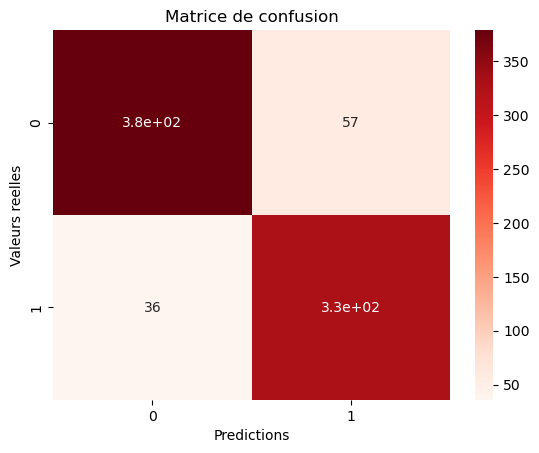

In [107]:
SVmodel = SVC(kernel='rbf', gamma=0.1, C=5.0)

SVmodel.fit(scaler.fit_transform(Xtrain), Ytrain)

Ypred = SVmodel.predict(scaler.transform(Xtest))

print('SVM rbf')
print(f'  * accuracy_score : {accuracy_score(Ypred, Ytest)}')
print(f'  * f1_score : {f1_score(Ypred, Ytest)}')

fig, ax = plt.subplots(1, 1)
sns.heatmap(confusion_matrix(Ypred, Ytest), annot=True, cmap='Reds', ax=ax)
ax.set_ylabel("Valeurs reelles")
ax.set_xlabel("Predictions")
ax.set_title("Matrice de confusion")

On obtient cette fois ci un score encore supérieur d'environ **88% d'accuracy** pour la classification des signaux et un taux de faux positifs et de faux négatifs toujours relativement équilibré au vu de la matrice de confusion ci-dessus (57 signaux classés comme 'menace' à tord et 36 menaces non détéctées).

On peut cependant considérer que la détection des menaces doit être à privilégier sur l'erreur des fausses menaces. On peut ainsi faire varier le seuil de décision en probabilité du modèle pour obtenir davantage d'asssurance (meilleur score de rappel) même ci cela réduit la précision du modèle en parallèle :

SVM rbf, proba > 0.8
  * accuracy_score : 0.86875
  * f1_score : 0.8476052249637155


Text(0.5, 1.0, 'Matrice de confusion')

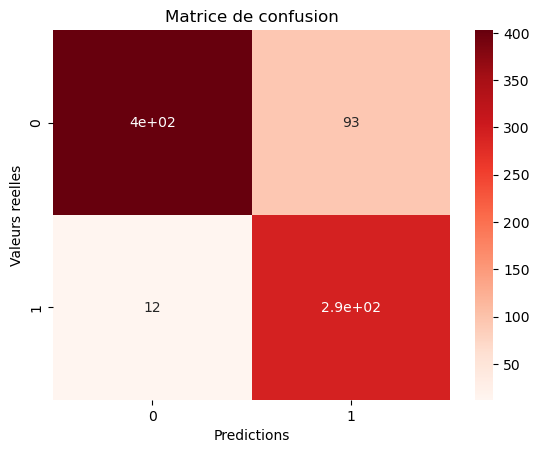

In [109]:
SVmodel = SVC(probability = True, kernel='rbf', gamma=0.1, C=5.0)

SVmodel.fit(scaler.fit_transform(Xtrain), Ytrain)

Ypred_proba = SVmodel.predict_proba(scaler.transform(Xtest))[:,1]

seuil = 0.8

Ypred = Ypred_proba > seuil

print(f'SVM rbf, proba > {seuil}')
print(f'  * accuracy_score : {accuracy_score(Ypred, Ytest)}')
print(f'  * f1_score : {f1_score(Ypred, Ytest)}')

fig, ax = plt.subplots(1, 1)
sns.heatmap(confusion_matrix(Ypred, Ytest), annot=True, cmap='Reds', ax=ax)
ax.set_ylabel("Valeurs reelles")
ax.set_xlabel("Predictions")
ax.set_title("Matrice de confusion")

On observe la qualité du compromis rappel/précision en affichant la courbe ROC sur les deux modèles de regression logistique et SVM :

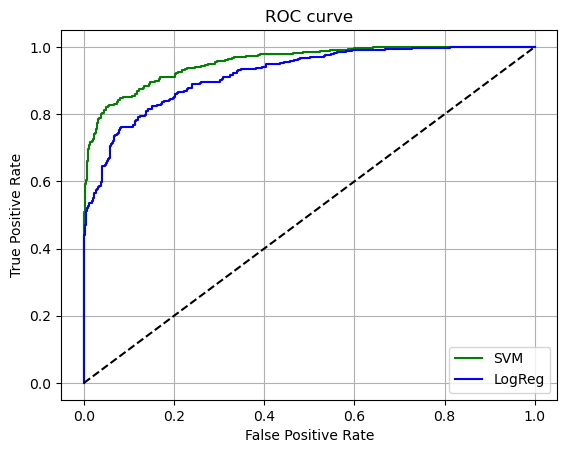

In [111]:
from sklearn.metrics import roc_curve

Ypred_proba_log = LRmodel.predict_proba(Xtest)[:,1]
Ypred_proba_svm = SVmodel.predict_proba(scaler.transform(Xtest))[:,1]

FPR_log, TPR_log, _ = roc_curve(Ytest, Ypred_proba_log)
FPR_svm, TPR_svm, _ = roc_curve(Ytest, Ypred_proba_svm)


plt.plot(FPR_svm, TPR_svm, color='green', label='SVM')
plt.plot(FPR_log, TPR_log, color='blue', label='LogReg')
plt.grid()
plt.plot([0,1], [0, 1], linestyle='--', color='black')
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

On voit ici que le modèle SVM tend davantage vers le point idéal (0, 1) où le taux de faux positifs est plus tolérant (augmente moins) à l'amélioration du taux de vrais positifs et possède ainsi un meilleur compromis rappel/précision quelque soit le seuil de probabilité choisi.